<a href="https://colab.research.google.com/github/flaviorv/ai_model_lifecycle/blob/main/model_battle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#KNN vs Random Forests

###Imports

In [59]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


###Loading, Splitting, Scaling and adding Sythetic Data

In [56]:
#Loading
breast_cancer = load_breast_cancer()
x = breast_cancer.data
y = breast_cancer.target
#Separating train, validation and test
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8, random_state=42)
#Scaling
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)
#Generating synthetic data for train
print('Train data:', len(y_train))
smote = SMOTE(random_state=42)
x_train, y_train = smote.fit_resample(x_train, y_train)
print('With synthetic:', len(y_train))
#Adding noise
noise = np.random.normal(loc=0, scale=0.5, size=x_train.shape)
x_train = np.vstack([x_train, x_train + noise])
y_train = np.hstack([y_train, y_train])
print('With noise:', len(y_train))

Train data: 364
With synthetic: 462
With noise: 924


###Selecting features and hyperparameters

####KNN

Recall 0.98  Neighbors  10 Features   5
Recall 1.00  Neighbors  10 Features  15
Recall 0.98  Neighbors  10 Features  25
Recall 1.00  Neighbors  30 Features   5
Recall 1.00  Neighbors  30 Features  15
Recall 1.00  Neighbors  30 Features  25
Recall 1.00  Neighbors  50 Features   5
Recall 1.00  Neighbors  50 Features  15
Recall 1.00  Neighbors  50 Features  25


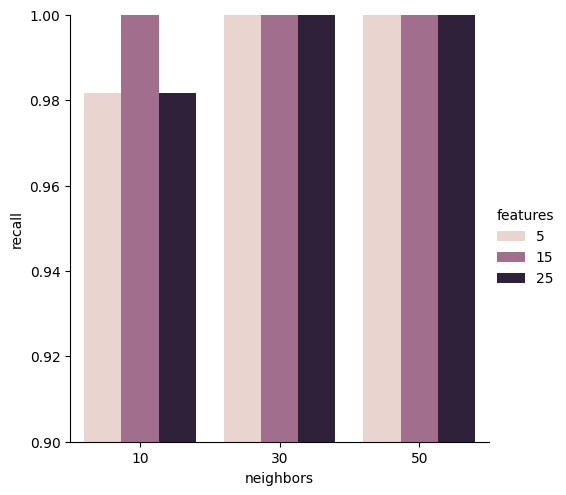

In [57]:
#Result of the wrapper feature selector
result = {
    'recall': [],
    'features': [],
    'neighbors': [],
    'masks': {}
}

#KNN Wrapper with different number of neighbors and features
for nk in [10, 30, 50]:
  for nf in [5, 15, 25]:
    knn = KNN(n_neighbors=nk)
    sfs = SFS(
        estimator=knn,
        n_features_to_select=nf,
        scoring='recall',
        cv=2,
        n_jobs=-1
    )

    sfs.fit(x_train, y_train)
    mask = sfs.get_support(indices=True)
    recall = cross_val_score(knn, x_val[:, mask], y_val, cv=5, scoring='recall')
    recall_mean = recall.mean()
    print(f"Recall {recall.mean():<5.2f} Neighbors {nk:>3} Features {nf:>3}")
    result['recall'].append(recall_mean)
    result['neighbors'].append(nk)
    result['features'].append(nf)
    result['masks'][f'{nk}_{nf}'] = mask

chart = sns.catplot(data=result, x="neighbors", y="recall", hue='features', kind='bar')
chart.set(ylim=(0.9, 1.0))

####Radom Forest

In [61]:
#Result of the wrapper and hyperparams
rf_result = {
    'recall': [],
    'masks': [],
    'hp': []
}

#Random Forest Wrapper with different n trees, n features and depth
for ne in [50, 100, 200]:
  for md in [3, 5, 10]:
    for nf in [5, 15, 25]:
      rf = RandomForestClassifier(
          n_estimators=ne,
          max_depth=md,
          random_state=42
      )

      rf_sfs = SFS(
        estimator=rf,
        n_features_to_select=nf,
        scoring='recall',
        cv=2,
        n_jobs=-1
      )

      rf_sfs.fit(x_train, y_train)
      mask = rf_sfs.get_support(indices=True)
      rf_recall = cross_val_score(knn, x_val[:, mask], y_val, cv=5, scoring='recall')
      rf_recall_mean = rf_recall.mean()
      print(f"rf_recall {rf_recall.mean():<5.2f} Trees {ne:>3} MaxDepth {md:>3} Features {nf:>3}")
      rf_result['recall'].append(recall_mean)
      rf_result['masks'].append(mask)
      rf_result['hp'].append(f'{ne}_{md}_{nf}')



rf_recall 1.00  Trees  50 MaxDepth   3 Features   5
rf_recall 0.98  Trees  50 MaxDepth   3 Features  15
rf_recall 1.00  Trees  50 MaxDepth   3 Features  25
rf_recall 0.96  Trees  50 MaxDepth   5 Features   5
rf_recall 1.00  Trees  50 MaxDepth   5 Features  15
rf_recall 1.00  Trees  50 MaxDepth   5 Features  25
rf_recall 1.00  Trees  50 MaxDepth  10 Features   5
rf_recall 1.00  Trees  50 MaxDepth  10 Features  15
rf_recall 0.98  Trees  50 MaxDepth  10 Features  25
rf_recall 1.00  Trees 100 MaxDepth   3 Features   5
rf_recall 1.00  Trees 100 MaxDepth   3 Features  15
rf_recall 1.00  Trees 100 MaxDepth   3 Features  25
rf_recall 1.00  Trees 100 MaxDepth   5 Features   5
rf_recall 1.00  Trees 100 MaxDepth   5 Features  15
rf_recall 1.00  Trees 100 MaxDepth   5 Features  25
rf_recall 1.00  Trees 100 MaxDepth  10 Features   5
rf_recall 1.00  Trees 100 MaxDepth  10 Features  15
rf_recall 1.00  Trees 100 MaxDepth  10 Features  25
rf_recall 0.96  Trees 200 MaxDepth   3 Features   5
rf_recall 1.

ValueError: Could not interpret value `md` for `hue`. An entry with this name does not appear in `data`.

###Retrain and Test

####KNN

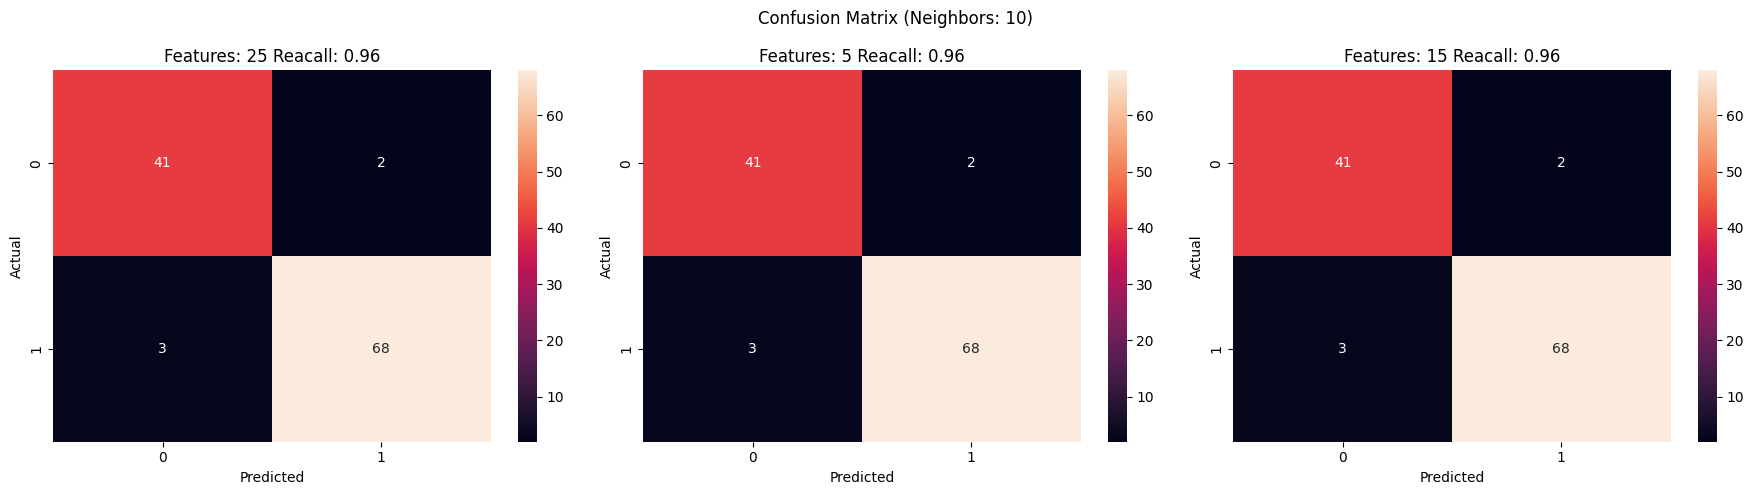

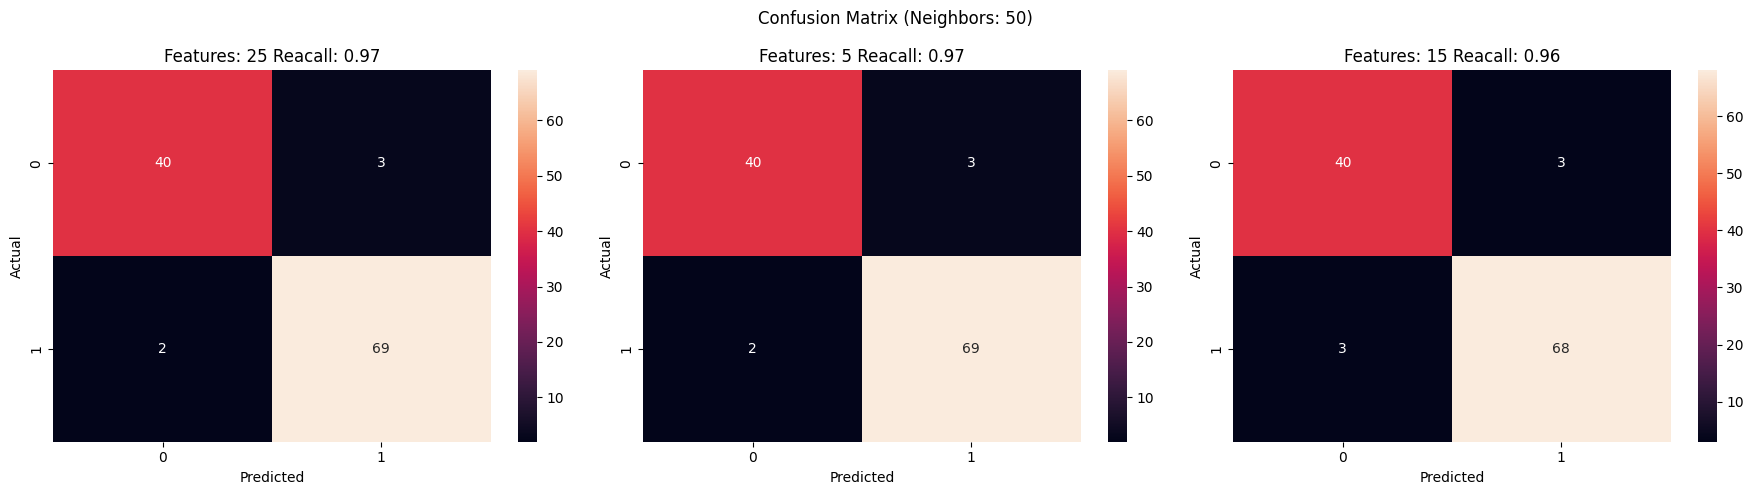

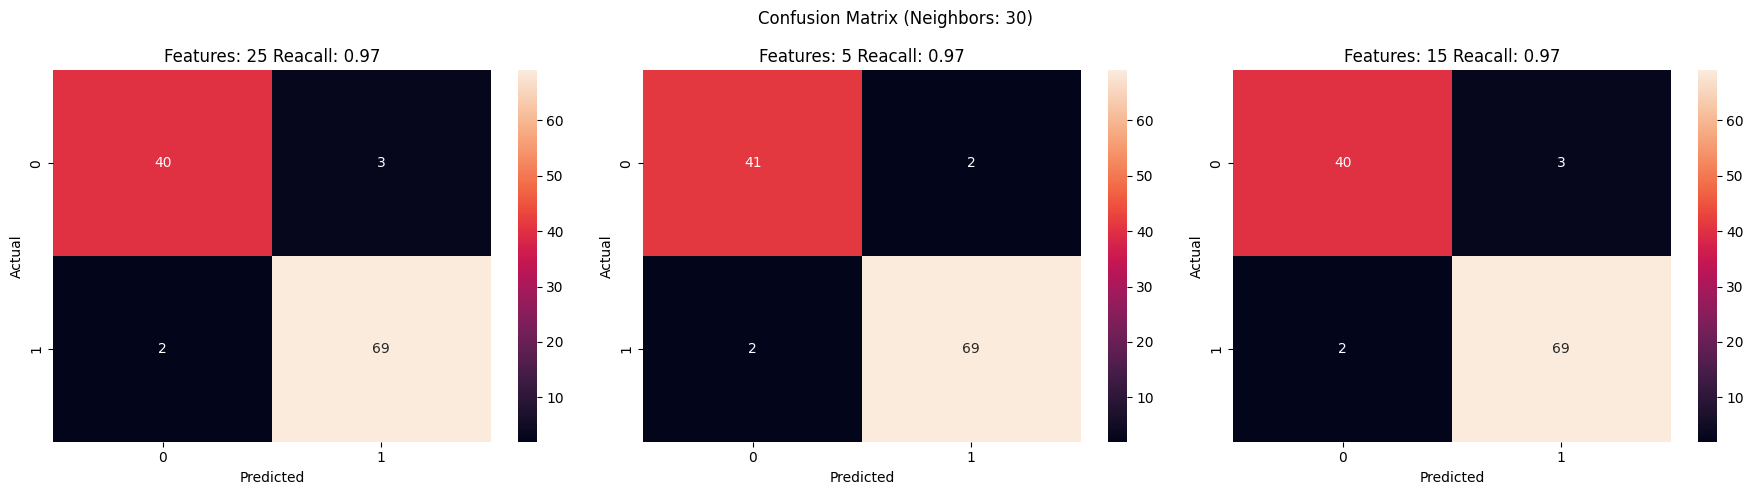

In [80]:
nks = list(set(result['neighbors']))
nfs = list(set(result['features']))
masks = result['masks']
best_knn = [0]
#Train and predict with different features and k neighbors
for i in range(len(nks)):
  knn = KNN(n_neighbors=nks[i])
  fig, axes = plt.subplots(1, len(nfs), figsize=(18, 5))
  for j in range(len(nfs)):
    #Train and predict
    selected_features = result['masks'][f'{nks[i]}_{nfs[j]}']
    knn.fit(x_train[:, selected_features], y_train)
    y_pred = knn.predict(x_test[:, selected_features])
    recall = recall_score(y_test, y_pred)
    if recall > best_knn[0]:
      best_knn = (recall, nfs[j], nks[i])
    #Ploting Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, ax=axes[j])
    axes[j].set_xlabel('Predicted')
    axes[j].set_ylabel('Actual')
    axes[j].set_title(f'Features: {nfs[j]} Reacall: {recall:.2f}')
  plt.suptitle(f'Confusion Matrix (Neighbors: {nks[i]})')
  plt.tight_layout()


####Random Forest

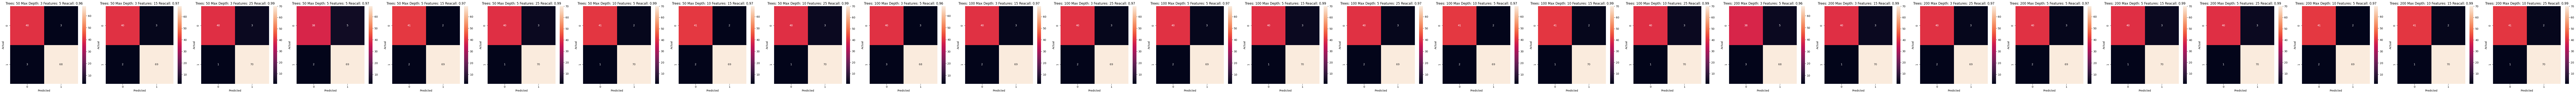

In [81]:
fig, axes = plt.subplots(1, len(rf_result['hp']), figsize=(5 * len(rf_result['hp']), 5))
best_rf = [0]
for i, hp in enumerate(rf_result['hp']):
  #Getting hyperparams
  splited = hp.split('_')
  ne = splited[0]
  md = splited[1]
  nf = splited[2]

  rf = RandomForestClassifier(
    n_estimators=int(ne),
    max_depth=int(md),
    random_state=42
  )
  plt.plot(figsize=(18, 5))
  #Train and predict
  selected_features = rf_result['masks'][i]
  rf.fit(x_train[:, selected_features], y_train)
  y_pred = rf.predict(x_test[:, selected_features])
  rf_recall = recall_score(y_test, y_pred)
  if rf_recall > best_rf[0]:
    best_rf = (rf_recall, ne, md, nf)
  #Ploting Confusion Matrix
  cm = confusion_matrix(y_test, y_pred)
  sns.heatmap(cm, annot=True, fmt='d', ax=axes[i])
  axes[i].set_xlabel('Predicted')
  axes[i].set_ylabel('Actual')
  axes[i].set_title(f'Trees: {ne} Max Depth: {md} Features: {nf} Reacall: {rf_recall:.2f}')
plt.tight_layout()
plt.show()

###Winner

In [87]:
winner = ''
print(f'Best KNN: Recall {best_knn[0]:.2f} Neighbors {best_knn[2]} Features {best_knn[1]}')
print(f'Best Random Forest: Recall {best_rf[0]:.2f} Trees {best_rf[1]} Max Depth {best_rf[2]} Features {best_rf[3]}')
print('\nWinner:', end=' ')
if best_knn[0] > best_rf[0]:
  print('KNN')
elif best_knn[0] < best_rf[0]:
  print('Random Forest')
else:
  print('Draw')

Best KNN: Recall 0.97 Neighbors 50 Features 25
Best Random Forest: Recall 0.99 Trees 50 Max Depth 3 Features 25

Winner: Random Forest
